In [1]:
# python version 3.6.9 #
import pandas as pd # 1.1.5
import numpy as np # 1.19.5
import matplotlib.pyplot as plt
import matplotlib # 3.3.4
import scipy.stats as st # scipy 1.5.4
import random

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rc('text', usetex=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('source_data/included/figure.style')
cm = plt.cm.get_cmap('Accent')
from scipy.stats import hypergeom
import seaborn as sns
from scipy.spatial import distance
from scipy.cluster import hierarchy
import scipy


In [2]:
bnum_table = pd.read_csv('source_data/included/ecoli_bnum_table_updated_2.txt',sep='\t',index_col=0)
bnum_table = bnum_table.drop_duplicates()
bnum_table.index = bnum_table['gene']

def make_table(filename,FDR):
    table = pd.read_csv(filename,sep='\t',index_col=0)
    table.index = table['Row.names']
    table = table.drop('Row.names',axis=1)
    table = table.merge(bnum_table,left_index=True,right_index=True)
    table['less'] = -table['less']
    signed_p = []
    for h,l in zip(table['greater'],table['less']):
        if abs(h)<=abs(l):
            signed_p.append(h + (10**-280))
        elif abs(l)<abs(h):
            signed_p.append(l - (10**-280))
        else:
            print('error')
    table['signed_p'] = signed_p
    table['fixed_signif'] = (abs(table['signed_p']).sort_values()<FDR*np.arange(1,len(table)+1)/len(table)).astype(int)
    table['fixed_signif'] = (table['fixed_signif'] * (table['signed_p']/abs(table['signed_p']))).astype(int)
    return table

## "_vs_5.txt" tables are made by figED2_markers_vs_clust5.R
tables = {}
FDR = 0.01
tables['metG_clust2'] = make_table('source_data/generated/v4_metG_clust2_vs_5.txt',FDR)
tables['d6_clust2'] = make_table('source_data/generated/v4_d6_clust2_vs_5.txt',FDR)
tables['hipA7_clust2'] = make_table('source_data/generated/v4_hipA7_clust2_vs_5.txt',FDR)
tables['metG_amp'] = make_table('source_data/generated/v4_metG_amp_vs_5.txt',FDR)
tables['d6_amp'] = make_table('source_data/generated/v4_d6_amp_vs_5.txt',FDR)
tables['wt_amp']  = make_table('source_data/generated/v4_wt_amp_vs_5.txt',FDR)
tables['tet'] = make_table('source_data/generated/v4_tet_vs_5.txt',FDR)
tables['stat'] = make_table('source_data/generated/v4_clust1_vs_5.txt',FDR)

counts = {}
counts['metG_clust2'] = pd.read_csv('source_data/generated/v4_metG_clust2_vs_5_counts.txt',sep='\t')
counts['d6_clust2'] = pd.read_csv('source_data/generated/v4_d6_clust2_vs_5_counts.txt',sep='\t')
counts['hipA7_clust2'] = pd.read_csv('source_data/generated/v4_hipA7_clust2_vs_5_counts.txt',sep='\t')
counts['metG_amp'] = pd.read_csv('source_data/generated/v4_metG_amp_vs_5_counts.txt',sep='\t')
counts['d6_amp'] = pd.read_csv('source_data/generated/v4_d6_amp_vs_5_counts.txt',sep='\t')
counts['wt_amp'] = pd.read_csv('source_data/generated/v4_wt_amp_vs_5_counts.txt',sep='\t')
counts['tet'] = pd.read_csv('source_data/generated/v4_tet_vs_5_counts.txt',sep='\t')
counts['stat'] = pd.read_csv('source_data/generated/v4_clust1_vs_5_counts.txt',sep='\t')


In [3]:
## save source data
for_table = pd.DataFrame()
for key in tables.keys():
    temp = tables[key][['logFC','signed_p','fixed_signif']]
    temp.insert(3,"type",[key] * len(temp),True)
    for_table = for_table.append(temp)
for_table.to_csv('source_data/source_tables/figED2.txt',sep='\t')

In [4]:
### get all p-values (hyper-geometric test) ###
def get_p(s1,s2):
    print(s1 + ' / ' + s2)
    df = tables[s1].reindex(labels=tables[s1].merge(tables[s2],left_index=True,right_index=True,how='inner').index).dropna()
    archive_df = df.copy()
    df = df.loc[df['fixed_signif']!=0]
    df = df.reindex(tables[s2].loc[tables[s2]['fixed_signif']==1].index).dropna()
    M = len(archive_df)             # population size
    n = (archive_df['fixed_signif']==1).sum()  # number of successes in population
    N = (tables[s2].reindex(archive_df.index).dropna()['fixed_signif']==1).sum()  # number sampled
    x = (df['fixed_signif']==1).sum()  # number of drawn successes
    print(hypergeom.sf(x-1, M, n, N))

samples = ['metG_clust2','hipA7_clust2','d6_clust2','tet','stat','metG_amp','d6_amp','wt_amp']
for s1 in samples:
    stop = False
    for s2 in samples:
        if stop == False:
            if s1 == s2:
                stop = True
            else:
                get_p(s1,s2)


hipA7_clust2 / metG_clust2
5.265229026852983e-96
d6_clust2 / metG_clust2
2.5414437042505278e-20
d6_clust2 / hipA7_clust2
3.3764439717092787e-15
tet / metG_clust2
1.1194198891601577e-32
tet / hipA7_clust2
1.0746284286579154e-25
tet / d6_clust2
3.663527680140026e-38
stat / metG_clust2
8.762187084701515e-200
stat / hipA7_clust2
7.556782830132159e-28
stat / d6_clust2
3.197610703355673e-07
stat / tet
0.012239810045058107
metG_amp / metG_clust2
6.66611487044429e-238
metG_amp / hipA7_clust2
1.9864044867696388e-48
metG_amp / d6_clust2
3.626918438026345e-18
metG_amp / tet
3.396857394233707e-17
metG_amp / stat
2.3256435361666185e-190
d6_amp / metG_clust2
5.6802543217988706e-08
d6_amp / hipA7_clust2
0.00040714097637586005
d6_amp / d6_clust2
2.742774568533125e-16
d6_amp / tet
1.5498746783482493e-36
d6_amp / stat
1.7213810020929944e-13
d6_amp / metG_amp
2.861658433424033e-08
wt_amp / metG_clust2
0.00751637499635692
wt_amp / hipA7_clust2
0.0006140557753563034
wt_amp / d6_clust2
1.2456740668331072e-0

In [5]:
## save all comparisons for ipage
## run discrete mode, P.1 ##

def save_for_ipage(s1):
    df = tables[s1]
    df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
    pd.DataFrame(df['fixed_signif'].values+1,index=df['bnum']).sort_values(0).to_csv('source_data/generated/' + s1 + '_FDR0.01_discrete_vs_5.txt',sep='\t')

for key in tables.keys():
    save_for_ipage(key)


2056
Index(['clpA', 'iscS', 'rmf', 'nlpD', 'rpoS', 'kgtP', 'cysK', 'deaD', 'mdtK',
       'aceB', 'ymgA', 'yhaM'],
      dtype='object')


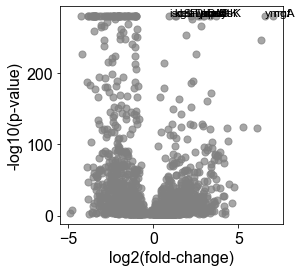

In [6]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'metG_clust2'

df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)

ax.set_xlabel('log2(fold-change)',size=16)
ax.set_ylabel('-log10(p-value)',size=16)

gene_set = df.sort_values('greater',ascending=True).iloc[0:12,].index
for gene in gene_set:
    ax.annotate(gene, (x[gene],y[gene]),size=12)
plt.savefig('figures/figED2a_left.pdf')

metG_clust2_gene_set = gene_set
print(len(x))
print(gene_set)

0.322677720160875
1.2545965447276


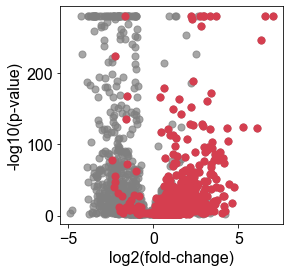

In [7]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'metG_clust2'
s2 = 'stat'

df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)
print(x.median())

df = df.reindex(tables[s2].loc[tables[s2]['fixed_signif']==1].index).dropna()
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='#D53E4F',alpha=1,label=s1 + ' only')
print(x.median())

ax.set_xlabel('log2(fold-change)',size=16)
ax.set_ylabel('-log10(p-value)',size=16)
plt.savefig('figures/figED2a_middle.pdf')


0.322677720160875
0.9606403731848305


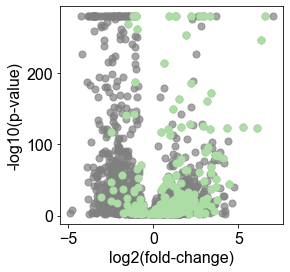

In [8]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'metG_clust2'
s2 = 'tet'

df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]

x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)
print(x.median())

df = df.reindex(tables[s2].loc[tables[s2]['fixed_signif']==1].index).dropna()
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color="#ABDDA4",alpha=1,label=s1 + ' only')
print(x.median())

ax.set_xlabel('log2(fold-change)',size=16)
ax.set_ylabel('-log10(p-value)',size=16)
plt.savefig('figures/figED2a_right.pdf')


527
Index(['frmR', 'frmA', 'ymgA', 'raiA', 'clpA', 'mdh', 'rmf', 'mqsR', 'ariR',
       'lpxC', 'rpoS', 'nlpD'],
      dtype='object')


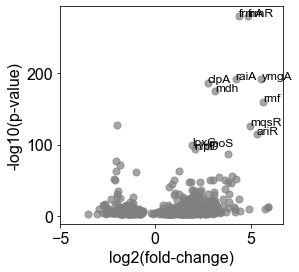

In [9]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'hipA7_clust2'

df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]

x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)
ax.set_xlabel('log2(fold-change)',size=16)
ax.set_ylabel('-log10(p-value)',size=16)

gene_set = df.sort_values('greater',ascending=True).iloc[0:12,].index
for gene in gene_set:
    ax.annotate(gene, (x[gene],y[gene]),size=12)

ax.set_xlim(-5,6.7)
plt.savefig('figures/figED2b_left.pdf')

hipA7_clust2_gene_set = gene_set
print(len(x))
print(gene_set)

1.3631643313881103
1.9332035832729901


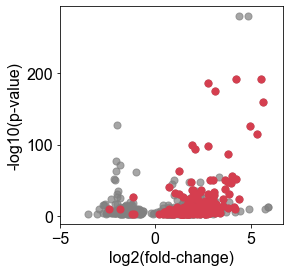

In [10]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'hipA7_clust2'
s2 = 'stat'

df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)
ax.set_xlim(-5,6.7)

print(x.median())

df = df.reindex(tables[s2].loc[tables[s2]['fixed_signif']==1].index).dropna()
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='#D53E4F',alpha=1,label=s1 + ' only')
print(x.median())

ax.set_xlabel('log2(fold-change)',size=16)
ax.set_ylabel('-log10(p-value)',size=16)
plt.savefig('figures/figED2b_middle.pdf')


1.3631643313881103
1.9130865827072152


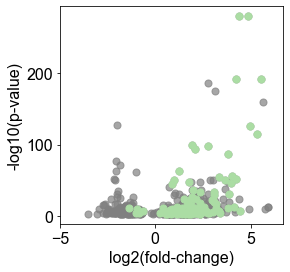

In [11]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'hipA7_clust2'
s2 = 'tet'

df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]

x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)
ax.set_xlim(-5,6.7)

print(x.median())

df = df.reindex(tables[s2].loc[tables[s2]['fixed_signif']==1].index).dropna()
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color="#ABDDA4",alpha=1,label=s1 + ' only')
print(x.median())

ax.set_xlabel('log2(fold-change)',size=16)
ax.set_ylabel('-log10(p-value)',size=16)
plt.savefig('figures/figED2b_right.pdf')


351
Index(['deaD', 'cspB', 'clpA', 'nlpD', 'ycbK', 'mntH', 'uxuA', 'ycbL', 'proP',
       'nlpI', 'cdaR', 'rpoS'],
      dtype='object')


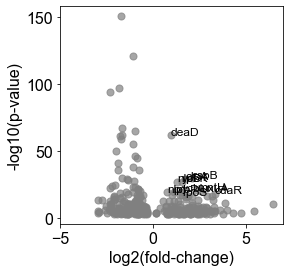

In [12]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'd6_clust2'

df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]

x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)
ax.set_xlabel('log2(fold-change)',size=16)
ax.set_ylabel('-log10(p-value)',size=16)
ax.set_xlim(-5,7)
gene_set = df.sort_values('greater',ascending=True).iloc[0:12,].index
for gene in gene_set:
    ax.annotate(gene, (x[gene],y[gene]),size=12)

plt.savefig('figures/figED2c_left.pdf')

d6_clust2_gene_set = gene_set
print(len(x))
print(gene_set)

In [13]:
## find shared top markers

print('all')
print(set(metG_clust2_gene_set).intersection(hipA7_clust2_gene_set).intersection(d6_clust2_gene_set))

print('metG, hipA7')
print(set(metG_clust2_gene_set).intersection(hipA7_clust2_gene_set).difference(d6_clust2_gene_set))

print('metG, d6')
print(set(metG_clust2_gene_set).intersection(d6_clust2_gene_set).difference(hipA7_clust2_gene_set))

print('hipA7, d6')
print(set(hipA7_clust2_gene_set).intersection(d6_clust2_gene_set).difference(metG_clust2_gene_set))


all
{'nlpD', 'clpA', 'rpoS'}
metG, hipA7
{'rmf', 'ymgA'}
metG, d6
{'deaD'}
hipA7, d6
set()


-0.729969019375021
1.6042366047071948


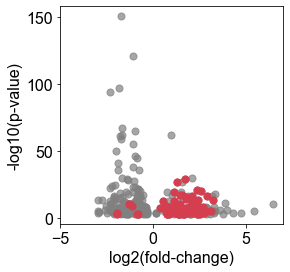

In [14]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'd6_clust2'
s2 = 'stat'

df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)
print(x.median())

df = df.reindex(tables[s2].loc[tables[s2]['fixed_signif']==1].index).dropna()
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='#D53E4F',alpha=1,label=s1 + ' only')
print(x.median())
ax.set_xlim(-5,7)

ax.set_xlabel('log2(fold-change)',size=16)
ax.set_ylabel('-log10(p-value)',size=16)
plt.savefig('figures/figED2c_middle.pdf')


-0.729969019375021
1.799543176699695


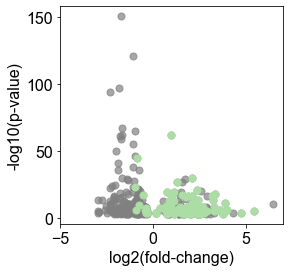

In [15]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'd6_clust2'
s2 = 'tet'

df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]

x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)
print(x.median())

df = df.reindex(tables[s2].loc[tables[s2]['fixed_signif']==1].index).dropna()
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color="#ABDDA4",alpha=1,label=s1 + ' only')
print(x.median())
ax.set_xlim(-5,7)

ax.set_xlabel('log2(fold-change)',size=16)
ax.set_ylabel('-log10(p-value)',size=16)
plt.savefig('figures/figED2c_right.pdf')



0.7425989303427369
2.35190061457992


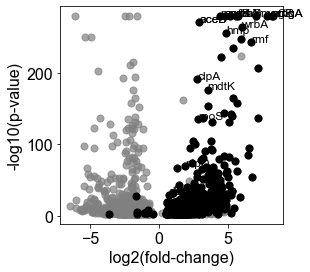

In [16]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'metG_amp'
s2 = 'metG_clust2'

df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]

x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)

print(x.median())

ax.set_xlabel('log2(fold-change)',size=16)
ax.set_ylabel('-log10(p-value)',size=16)

gene_set = df.sort_values('greater',ascending=True).iloc[0:12,].index
for gene in gene_set:
    ax.annotate(gene, (x[gene],y[gene]),size=12)
gene_set_2 = tables[s2].sort_values('greater').index[0:12] ## label upregulated genes shared with metG_clust2
for gene in gene_set_2:
    if gene in x.index:
        ax.annotate(gene, (x[gene],y[gene]),size=12)

df = df.reindex(tables[s2].loc[tables[s2]['fixed_signif']==1].index).dropna()
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color="k",alpha=1,label=s1 + ' only')
print(x.median())

plt.savefig('figures/figED2d.pdf')

1.9014384404953648
2.31867532133279


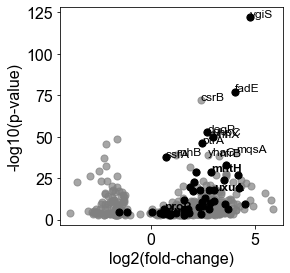

In [17]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'd6_amp'
s2 = 'd6_clust2'
df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]

x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)
print(x.median())

ax.set_xlabel('log2(fold-change)',size=16)
ax.set_ylabel('-log10(p-value)',size=16)

gene_set = df.sort_values('greater',ascending=True).iloc[0:12,].index
for gene in gene_set:
    ax.annotate(gene, (x[gene],y[gene]),size=12)
gene_set_2 = tables[s2].sort_values('greater').index[0:9] ## label upregulated genes shared with d6_clust2
for gene in gene_set_2:
    if gene in x.index:
        ax.annotate(gene, (x[gene],y[gene]),size=12,weight='bold')

df = df.reindex(tables[s2].loc[tables[s2]['fixed_signif']==1].index).dropna()
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color="k",alpha=1,label=s1 + ' only')
print(x.median())

plt.savefig('figures/figED2e.pdf')

131
2.78571631314166
2.85205900664819


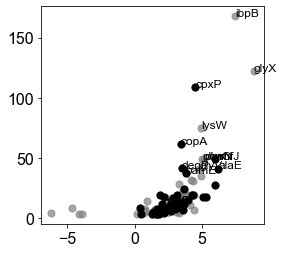

In [18]:
fig,ax = plt.subplots(figsize=(4,4))
cm = plt.cm.get_cmap('Accent')

s1 = 'wt_amp'
s2 = 'metG_clust2'

df = tables[s1]
df = df.merge(counts[s1].loc[counts[s1].min(axis=1)>0],how='inner',left_index=True,right_index=True).drop(['bulk.1','bulk.2'],axis=1)
archive_df = df.copy()
df = df.loc[df['fixed_signif']!=0]

x = df['logFC']
y = -np.log10(abs(df['signed_p']))
print(len(x))
ax.scatter(x,y,s=50,color='grey',alpha=0.7)
print(x.median())

gene_set = df.sort_values('greater',ascending=True).iloc[0:12,].index
for gene in gene_set:
    ax.annotate(gene, (x[gene],y[gene]),size=12)
gene_set_2 = tables[s2].sort_values('greater').index[0:12]
for gene in gene_set_2:
    if gene in x.index:
        ax.annotate(gene, (x[gene],y[gene]),size=12,weight='bold')

df = df.reindex(tables[s2].loc[tables[s2]['fixed_signif']==1].index).dropna()
x = df['logFC']
y = -np.log10(abs(df['signed_p']))
ax.scatter(x,y,s=50,color="k",alpha=1,label=s1 + ' only')
print(x.median())

plt.savefig('figures/figED2f.pdf')


In [19]:
## read in aggregated iPAGE output ## 
combined = pd.read_csv('source_data/included/discrete_vs_5_pvmatrix_combined.txt',sep='\t',index_col=0)
## clean up dataframe and make parsable ##
combined['comparison'] = combined.index.str.split('_FDR0.01_discrete',expand=True).droplevel(1)
combined['type'] = combined.index.str.split('_PO_',expand=True).droplevel(0).str.split('_P.1_PAGE',expand=True).droplevel(1)
combined = combined.reset_index().drop('index',axis=1)
for column in ['0','1','2']:
    combined = combined.merge(combined[column].str.split('/',expand=True).rename(columns={0:column+'_pval_enriched',1:column+'_pval_depleted'}).astype(float),left_index=True,right_index=True)
combined = combined.drop(['0','1','2'],axis=1)
## resulting combined dataframe gives p-value (from iPAGE) of enrichment or depletion in each gene classification ##
## gene classifications are 0 (significantly underexpressed), 1 (not differentially expressed), 2 (significantly overexpressed) ##


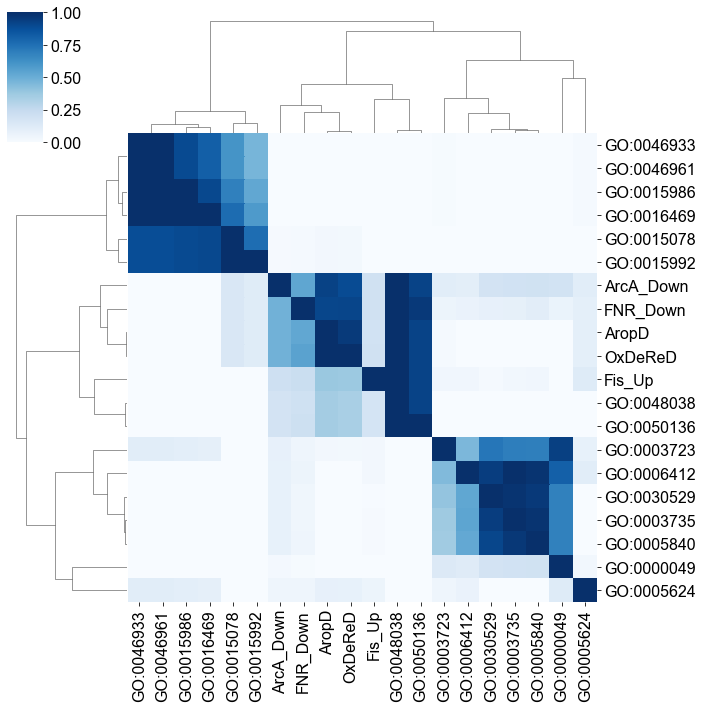

In [20]:
## find significantly downregulated pathways in persisters and then cluster to remove redundancy

df = (combined.loc[(combined['comparison']=='metG_clust2') | (combined['comparison']=='hipA7_clust2') | (combined['comparison']=='d6_clust2')])
df = df.loc[df['0_pval_enriched']<(-4)]
terms = df.groupby('GO')['type'].count()[df.groupby('GO')['type'].count()==3].index
genes_df = pd.DataFrame()
for term in terms:
    term = term.split(' ')[0]
    genes = []
    for term_type in ['go','tf','sr']:
        ref_file = open('source_data/included/Ecoli_' + term_type + '_index.txt')
        for line in ref_file:
            if term in line:
                genes.append(line.split('\t')[0])
    genes_df = genes_df.merge(pd.DataFrame([1]*len(genes),genes,columns=[term]),left_index=True,right_index=True,how='outer')
genes_df = genes_df.fillna(0)

percent_overlap_df = pd.DataFrame()
for i1 in np.arange(0,len(genes_df.columns)):
    percent_overlap = []
    for i2 in np.arange(0,len(genes_df.columns)):
        n_i1 = (genes_df.iloc[:,i1]==1).sum()
        n_overlap = (genes_df.iloc[:,[i1,i2]].sum(axis=1)==2).sum()
        percent_overlap.append(float(n_overlap)/n_i1)
    percent_overlap_df = percent_overlap_df.merge(pd.DataFrame(percent_overlap,genes_df.columns,columns=[genes_df.columns[i1]]),left_index=True,right_index=True,how='outer')

row_linkage = hierarchy.linkage(
    distance.pdist(percent_overlap_df), method='average')

sns.clustermap(percent_overlap_df, row_linkage=row_linkage, col_linkage=row_linkage, method="average",
               cmap='Blues')

## selected terms to show are GO:0006412, FNR_Down, GO:0016469


In [21]:
## check significance of each
combined.loc[combined['GO'].str.contains('0006412')].sort_values('0_pval_enriched')

,GO,comparison,type,0_pval_enriched,0_pval_depleted,1_pval_enriched,1_pval_depleted,2_pval_enriched,2_pval_depleted
487,GO:0006412 translation,stat,go,-41.968,-0.0,-0.000,-18.213,-0.000,-10.130
1422,GO:0006412 translation,metG_amp,go,-41.717,0.0,-0.000,-21.323,-0.000,-6.214
1112,GO:0006412 translation,d6_clust2,go,-36.900,0.0,0.000,-28.517,-0.038,-0.646
1661,GO:0006412 translation,metG_clust2,go,-33.339,0.0,-0.000,-14.973,-0.000,-6.243
983,GO:0006412 translation,d6_amp,go,-31.391,0.0,-0.000,-8.919,-0.000,-3.716
273,GO:0006412 translation,tet,go,-19.953,0.0,-0.000,-18.449,-0.429,-0.133
1242,GO:0006412 translation,hipA7_clust2,go,-8.941,-0.0,-0.000,-4.696,-0.233,-0.268
1913,GO:0006412 translation,wt_amp,go,-1.975,-0.0,-4.762,-0.000,0.000,-7.802
938,GO:0006412 translation,CFT_amp,go,-1.769,0.0,-3.068,-0.000,-0.000,-4.620


In [22]:
## check significance of each
combined.loc[combined['GO'].str.contains('FNR_Down')].sort_values('0_pval_enriched')

,GO,comparison,type,0_pval_enriched,0_pval_depleted,1_pval_enriched,1_pval_depleted,2_pval_enriched,2_pval_depleted
808,FNR_Down FNR_Down,tet,tf,-18.578,0.000,-0.000,-10.719,-0.001,-2.273
131,FNR_Down FNR_Down,metG_amp,tf,-15.212,0.000,0.000,-11.320,-0.134,-0.429
206,FNR_Down FNR_Down,metG_clust2,tf,-13.753,0.000,-0.000,-7.072,-0.004,-1.728
47,FNR_Down FNR_Down,d6_clust2,tf,-13.251,0.000,0.000,-10.634,-0.159,-0.272
862,FNR_Down FNR_Down,stat,tf,-8.820,-0.000,-0.000,-3.891,-0.007,-1.536
91,FNR_Down FNR_Down,hipA7_clust2,tf,-7.678,-0.000,-0.003,-1.893,-0.002,-1.874
22,FNR_Down FNR_Down,d6_amp,tf,-6.876,-0.000,-0.019,-1.139,-0.011,-1.298
976,FNR_Down FNR_Down,CFT_amp,tf,0.000,0.000,-1.939,-0.001,-0.001,-1.939
1951,FNR_Down FNR_Down,wt_amp,tf,0.000,-0.106,-2.577,-0.000,-0.000,-2.440


In [23]:
## check significance of each
combined.loc[combined['GO'].str.contains('0016469')].sort_values('0_pval_enriched')

,GO,comparison,type,0_pval_enriched,0_pval_depleted,1_pval_enriched,1_pval_depleted,2_pval_enriched,2_pval_depleted
990,GO:0016469 proton-transporting two-sector ATPa...,d6_amp,go,-9.370,-0.0,-0.000,-4.417,-0.0,-0.614
1118,GO:0016469 proton-transporting two-sector ATPa...,d6_clust2,go,-8.546,-0.0,-0.000,-6.895,-0.0,-0.192
1243,GO:0016469 proton-transporting two-sector ATPa...,hipA7_clust2,go,-8.092,-0.0,-0.000,-4.091,0.0,-0.615
1433,GO:0016469 proton-transporting two-sector ATPa...,metG_amp,go,-7.200,-0.0,0.000,-4.413,0.0,-0.817
286,GO:0016469 proton-transporting two-sector ATPa...,tet,go,-6.322,-0.0,-0.000,-4.316,0.0,-0.577
1682,GO:0016469 proton-transporting two-sector ATPa...,metG_clust2,go,-5.197,-0.0,-0.000,-2.004,0.0,-1.608
520,GO:0016469 proton-transporting two-sector ATPa...,stat,go,-4.636,-0.0,-0.001,-1.570,-0.0,-1.798


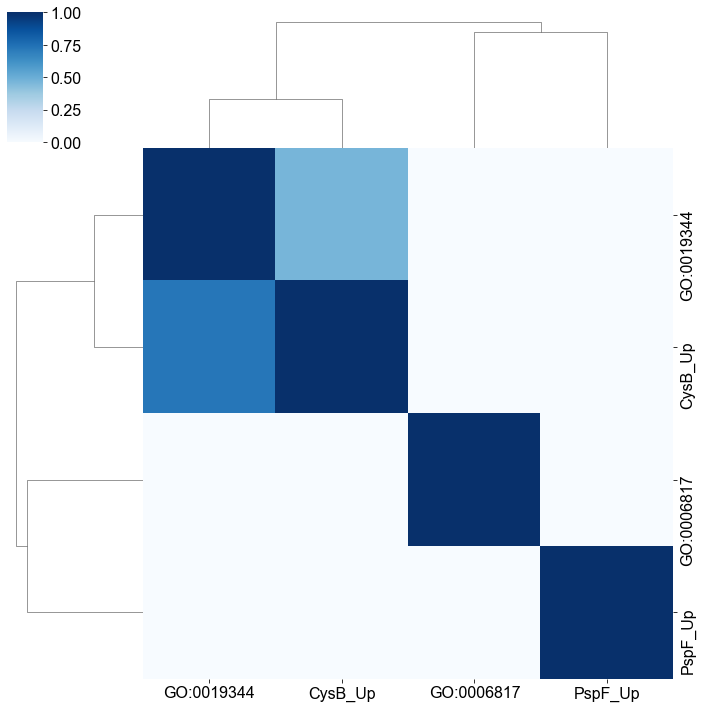

In [24]:
## find top upregulated pathways in metG* persisters and  cluster to remove redundancy

terms = combined.loc[(combined['2_pval_enriched']<np.log10(0.0005)) & (combined['comparison']=='metG_clust2')].sort_values('2_pval_enriched').iloc[0:4]['GO']
terms1 = terms.copy()
genes_df = pd.DataFrame()
for term in terms:
    term = term.split(' ')[0]
    genes = []
    for term_type in ['go','tf','sr']:
        ref_file = open('source_data/included/Ecoli_' + term_type + '_index.txt')
        for line in ref_file:
            if term in line:
                genes.append(line.split('\t')[0])
    genes_df = genes_df.merge(pd.DataFrame([1]*len(genes),genes,columns=[term]),left_index=True,right_index=True,how='outer')
genes_df = genes_df.fillna(0)

percent_overlap_df = pd.DataFrame()
for i1 in np.arange(0,len(genes_df.columns)):
    percent_overlap = []
    for i2 in np.arange(0,len(genes_df.columns)):
        n_i1 = (genes_df.iloc[:,i1]==1).sum()
        n_overlap = (genes_df.iloc[:,[i1,i2]].sum(axis=1)==2).sum()
        percent_overlap.append(float(n_overlap)/n_i1)
    percent_overlap_df = percent_overlap_df.merge(pd.DataFrame(percent_overlap,genes_df.columns,columns=[genes_df.columns[i1]]),left_index=True,right_index=True,how='outer')

row_linkage = hierarchy.linkage(
    distance.pdist(percent_overlap_df), method='average')

sns.clustermap(percent_overlap_df, row_linkage=row_linkage, col_linkage=row_linkage, method="average",
               cmap='Blues')


In [25]:
combined.loc[combined['GO'].str.contains('6817') & (combined['2_pval_enriched'] < np.log10(0.05))]


,GO,comparison,type,0_pval_enriched,0_pval_depleted,1_pval_enriched,1_pval_depleted,2_pval_enriched,2_pval_depleted
1312,GO:0006817 phosphate transport,hipA7_clust2,go,-0.407,-0.036,-0.001,-1.970,-1.798,-0.001
1691,GO:0006817 phosphate transport,metG_clust2,go,-0.027,-0.592,-0.000,-2.761,-4.040,-0.000


In [26]:
combined.loc[combined['GO'].str.contains('PspF_Up') & (combined['2_pval_enriched'] < np.log10(0.05))]


,GO,comparison,type,0_pval_enriched,0_pval_depleted,1_pval_enriched,1_pval_depleted,2_pval_enriched,2_pval_depleted
23,PspF_Up PspF_Up,d6_amp,tf,0.0,-0.086,0.000,-3.395,-3.837,-0.000
48,PspF_Up PspF_Up,d6_clust2,tf,-0.0,-0.218,-0.000,-2.822,-4.905,-0.000
92,PspF_Up PspF_Up,hipA7_clust2,tf,0.0,-0.186,0.000,-4.177,-5.266,0.000
146,PspF_Up PspF_Up,metG_amp,tf,0.0,-0.549,-0.001,-1.557,-3.051,-0.000
219,PspF_Up PspF_Up,metG_clust2,tf,-0.0,-0.696,-0.000,-1.780,-3.406,-0.000
813,PspF_Up PspF_Up,tet,tf,-0.0,-0.546,-0.000,-3.149,-5.761,0.000
918,PspF_Up PspF_Up,stat,tf,0.0,-0.684,-0.015,-0.720,-1.709,-0.001


In [27]:
combined.loc[combined['GO'].str.contains('19344') & (combined['2_pval_enriched'] < np.log10(0.05))]


,GO,comparison,type,0_pval_enriched,0_pval_depleted,1_pval_enriched,1_pval_depleted,2_pval_enriched,2_pval_depleted
548,GO:0019344 cysteine biosynthetic process,stat,go,-0.0,-1.569,-0.012,-0.963,-3.093,-0.0
1039,GO:0019344 cysteine biosynthetic process,d6_amp,go,-0.0,-0.182,-0.001,-1.714,-2.213,-0.0
1459,GO:0019344 cysteine biosynthetic process,metG_amp,go,-0.0,-1.019,-0.001,-1.812,-4.146,-0.0
1687,GO:0019344 cysteine biosynthetic process,metG_clust2,go,-0.0,-1.343,-0.000,-2.004,-4.548,-0.0


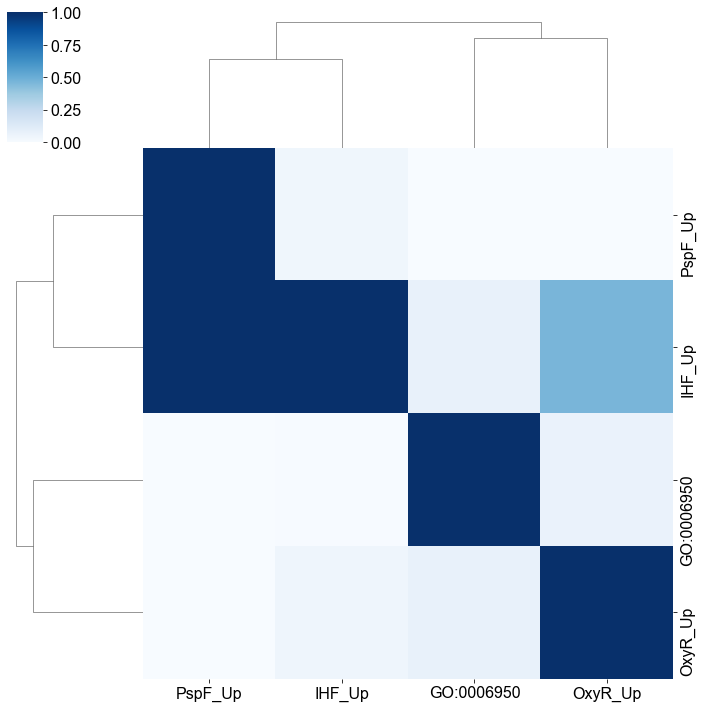

In [28]:
## find top upregulated pathways in hipA7 persisters and  cluster to remove redundancy

terms = combined.loc[(combined['2_pval_enriched']<0.0005) & (combined['comparison']=='hipA7_clust2')].sort_values('2_pval_enriched').iloc[0:4]['GO']
terms1 = terms.copy()
genes_df = pd.DataFrame()
for term in terms:
    term = term.split(' ')[0]
    genes = []
    for term_type in ['go','tf','sr']:
        ref_file = open('source_data/included/Ecoli_' + term_type + '_index.txt')
        for line in ref_file:
            if term in line:
                genes.append(line.split('\t')[0])
    genes_df = genes_df.merge(pd.DataFrame([1]*len(genes),genes,columns=[term]),left_index=True,right_index=True,how='outer')
genes_df = genes_df.fillna(0)

percent_overlap_df = pd.DataFrame()
for i1 in np.arange(0,len(genes_df.columns)):
    percent_overlap = []
    for i2 in np.arange(0,len(genes_df.columns)):
        n_i1 = (genes_df.iloc[:,i1]==1).sum()
        n_overlap = (genes_df.iloc[:,[i1,i2]].sum(axis=1)==2).sum()
        percent_overlap.append(float(n_overlap)/n_i1)
    percent_overlap_df = percent_overlap_df.merge(pd.DataFrame(percent_overlap,genes_df.columns,columns=[genes_df.columns[i1]]),left_index=True,right_index=True,how='outer')

row_linkage = hierarchy.linkage(
    distance.pdist(percent_overlap_df), method='average')

sns.clustermap(percent_overlap_df, row_linkage=row_linkage, col_linkage=row_linkage, method="average",
               cmap='Blues')


In [29]:
combined.loc[combined['GO'].str.contains('6950') & (combined['2_pval_enriched'] < np.log10(0.05))]


,GO,comparison,type,0_pval_enriched,0_pval_depleted,1_pval_enriched,1_pval_depleted,2_pval_enriched,2_pval_depleted
379,GO:0006950 response to stress,tet,go,0.0,-0.997,-0.104,-0.361,-1.550,-0.002
507,GO:0006950 response to stress,stat,go,0.0,-1.711,-0.000,-2.733,-6.070,-0.000
1265,GO:0006950 response to stress,hipA7_clust2,go,-0.0,-0.264,-0.000,-3.093,-4.128,-0.000
1450,GO:0006950 response to stress,metG_amp,go,-0.0,-1.112,-0.001,-2.137,-4.796,-0.000
1709,GO:0006950 response to stress,metG_clust2,go,0.0,-1.588,-0.008,-1.149,-3.390,-0.000


In [30]:
combined.loc[combined['GO'].str.contains('OxyR_Up') & (combined['2_pval_enriched'] < np.log10(0.05))]

,GO,comparison,type,0_pval_enriched,0_pval_depleted,1_pval_enriched,1_pval_depleted,2_pval_enriched,2_pval_depleted
96,OxyR_Up OxyR_Up,hipA7_clust2,tf,0.000,-0.466,-0.000,-2.356,-3.602,-0.000
167,OxyR_Up OxyR_Up,metG_amp,tf,-0.019,-0.719,-0.025,-0.844,-2.036,-0.001
228,OxyR_Up OxyR_Up,metG_clust2,tf,0.000,-1.747,-0.076,-0.496,-2.132,-0.001
812,OxyR_Up OxyR_Up,tet,tf,-0.019,-0.714,-0.000,-4.082,-7.683,-0.000
937,OxyR_Up OxyR_Up,stat,tf,-0.150,-0.273,-0.007,-1.235,-1.459,-0.004


In [31]:
combined.loc[combined['GO'].str.contains('PspF_Up') & (combined['2_pval_enriched'] < np.log10(0.05))]

,GO,comparison,type,0_pval_enriched,0_pval_depleted,1_pval_enriched,1_pval_depleted,2_pval_enriched,2_pval_depleted
23,PspF_Up PspF_Up,d6_amp,tf,0.0,-0.086,0.000,-3.395,-3.837,-0.000
48,PspF_Up PspF_Up,d6_clust2,tf,-0.0,-0.218,-0.000,-2.822,-4.905,-0.000
92,PspF_Up PspF_Up,hipA7_clust2,tf,0.0,-0.186,0.000,-4.177,-5.266,0.000
146,PspF_Up PspF_Up,metG_amp,tf,0.0,-0.549,-0.001,-1.557,-3.051,-0.000
219,PspF_Up PspF_Up,metG_clust2,tf,-0.0,-0.696,-0.000,-1.780,-3.406,-0.000
813,PspF_Up PspF_Up,tet,tf,-0.0,-0.546,-0.000,-3.149,-5.761,0.000
918,PspF_Up PspF_Up,stat,tf,0.0,-0.684,-0.015,-0.720,-1.709,-0.001


In [32]:
combined.loc[combined['GO'].str.contains('IHF_Up') & (combined['2_pval_enriched'] < np.log10(0.05))][['comparison','2_pval_enriched']]

,comparison,2_pval_enriched
27,d6_amp,-3.362
55,d6_clust2,-2.189
99,hipA7_clust2,-3.636
154,metG_amp,-1.937
217,metG_clust2,-2.040
864,stat,-4.280
975,CFT_amp,-2.460
1955,wt_amp,-1.748


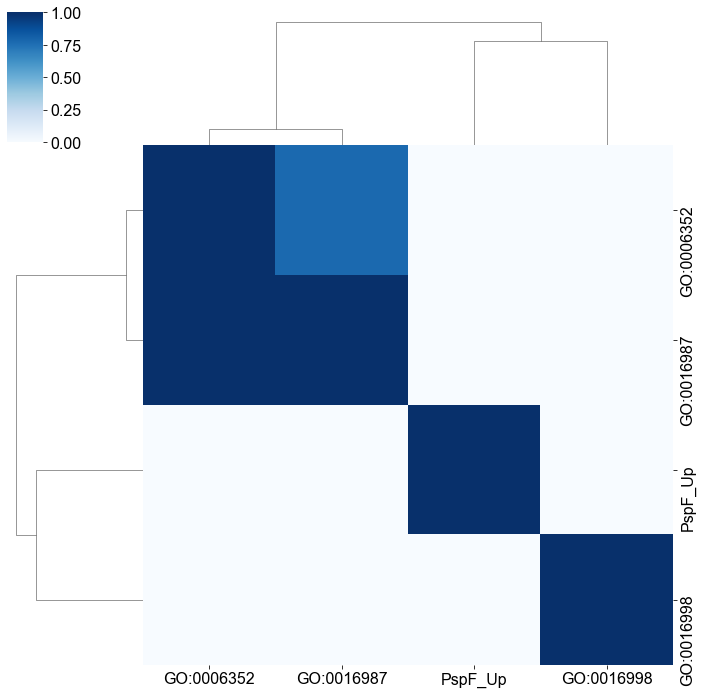

In [33]:
## find top upregulated pathways in 6-day wildtype persisters and  cluster to remove redundancy

terms = combined.loc[(combined['2_pval_enriched']<np.log10(0.0005)) & (combined['comparison']=='d6_clust2')].sort_values('2_pval_enriched').iloc[0:4]['GO']
terms1 = terms.copy()
genes_df = pd.DataFrame()
for term in terms:
    term = term.split(' ')[0]
    genes = []
    for term_type in ['go','tf','sr']:
        ref_file = open('source_data/included/Ecoli_' + term_type + '_index.txt')
        for line in ref_file:
            if term in line:
                genes.append(line.split('\t')[0])
    genes_df = genes_df.merge(pd.DataFrame([1]*len(genes),genes,columns=[term]),left_index=True,right_index=True,how='outer')
genes_df = genes_df.fillna(0)

percent_overlap_df = pd.DataFrame()
for i1 in np.arange(0,len(genes_df.columns)):
    percent_overlap = []
    for i2 in np.arange(0,len(genes_df.columns)):
        n_i1 = (genes_df.iloc[:,i1]==1).sum()
        n_overlap = (genes_df.iloc[:,[i1,i2]].sum(axis=1)==2).sum()
        percent_overlap.append(float(n_overlap)/n_i1)
    percent_overlap_df = percent_overlap_df.merge(pd.DataFrame(percent_overlap,genes_df.columns,columns=[genes_df.columns[i1]]),left_index=True,right_index=True,how='outer')

row_linkage = hierarchy.linkage(
    distance.pdist(percent_overlap_df), method='average')

sns.clustermap(percent_overlap_df, row_linkage=row_linkage, col_linkage=row_linkage, method="average",
               cmap='Blues')


In [34]:
combined.loc[combined['GO'].str.contains('6352') & (combined['2_pval_enriched'] < np.log10(0.05))][['comparison','2_pval_enriched']]

,comparison,2_pval_enriched
1020,d6_amp,-2.594
1132,d6_clust2,-4.142
1307,hipA7_clust2,-1.580
1526,metG_amp,-2.021


In [35]:
combined.loc[combined['GO'].str.contains('16998') & (combined['2_pval_enriched'] < np.log10(0.05))]

,GO,comparison,type,0_pval_enriched,0_pval_depleted,1_pval_enriched,1_pval_depleted,2_pval_enriched,2_pval_depleted
346,GO:0016998 cell wall catabolic process,tet,go,-0.0,-1.179,-0.080,-0.455,-1.963,-0.001
1134,GO:0016998 cell wall catabolic process,d6_clust2,go,-0.0,-0.437,-0.001,-1.962,-4.068,-0.000
1538,GO:0016998 cell wall catabolic process,metG_amp,go,-0.0,-1.112,-0.120,-0.342,-1.397,-0.004
